In [41]:
# Load libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [47]:
# Load feather file
df = pd.read_feather("../processed_data/obesity_cleaned.feather")

# Quick check
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     2111 non-null   category
 1   age                        2111 non-null   float64 
 2   height_m                   2111 non-null   float64 
 3   weight_kg                  2111 non-null   float64 
 4   family_history_overweight  2111 non-null   category
 5   high_caloric_food_freq     2111 non-null   category
 6   vegetables_freq            2111 non-null   category
 7   main_meal_count            2111 non-null   category
 8   snacking_freq              2111 non-null   category
 9   smokes                     2111 non-null   category
 10  water_intake               2111 non-null   category
 11  calorie_tracking           2111 non-null   category
 12  physical_activity_freq     2111 non-null   category
 13  screen_time_hours          2111 n

,gender,age,height_m,weight_kg,family_history_overweight,high_caloric_food_freq,vegetables_freq,main_meal_count,snacking_freq,smokes,water_intake,calorie_tracking,physical_activity_freq,screen_time_hours,alcohol_consumption_freq,transport_mode,obesity_level
0,Female,21.0,1.62,64.0,yes,no,Sometimes,Three,Sometimes,no,Between 1 and 2 L,no,I do not have,3-5 hours,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,Always,Three,Sometimes,yes,More than 2 L,yes,4 or 5 days,0-2 hours,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,Sometimes,Three,Sometimes,no,Between 1 and 2 L,no,2 or 4 days,3-5 hours,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,Always,Three,Sometimes,no,Between 1 and 2 L,no,2 or 4 days,0-2 hours,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,Sometimes,Between 1 y 2,Sometimes,no,Between 1 and 2 L,no,I do not have,0-2 hours,Sometimes,Public_Transportation,Overweight_Level_II


In [48]:
# Summary for numerical variables
df.describe()

,age,height_m,weight_kg
count,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058
std,6.345968,0.093305,26.191172
min,14.000000,1.450000,39.000000
25%,19.947192,1.630000,65.473343
50%,22.777890,1.700499,83.000000
75%,26.000000,1.768464,107.430682
max,61.000000,1.980000,173.000000


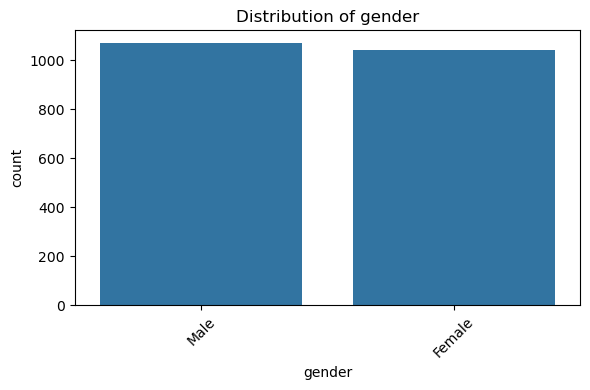

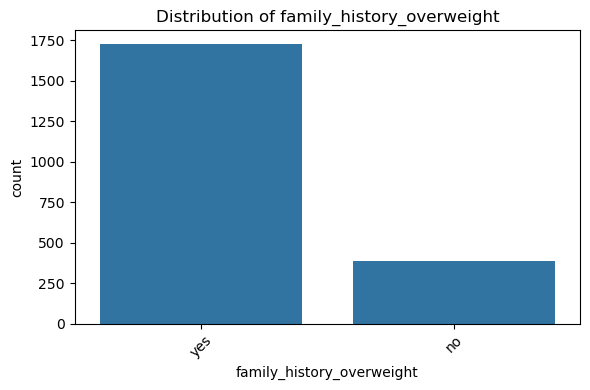

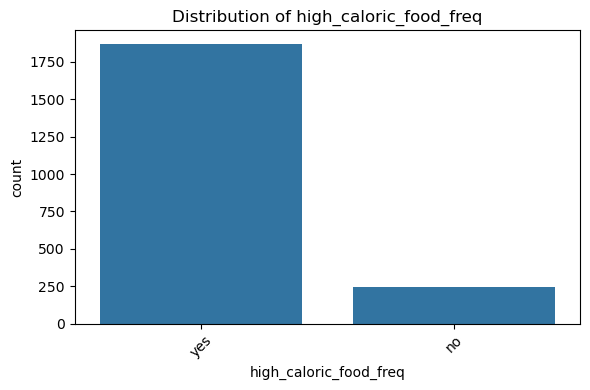

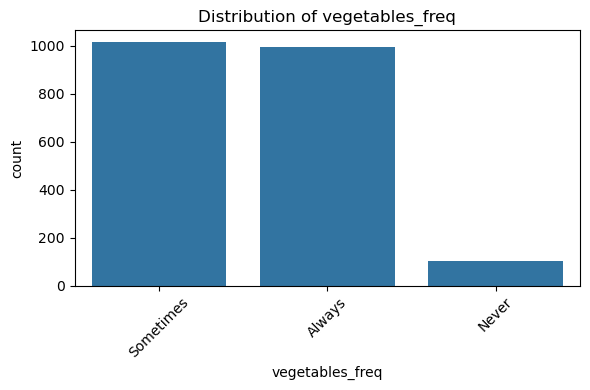

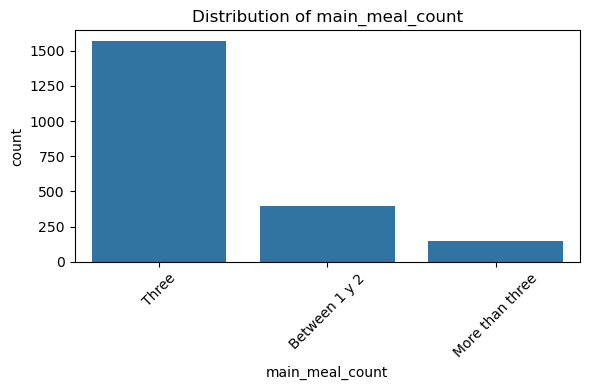

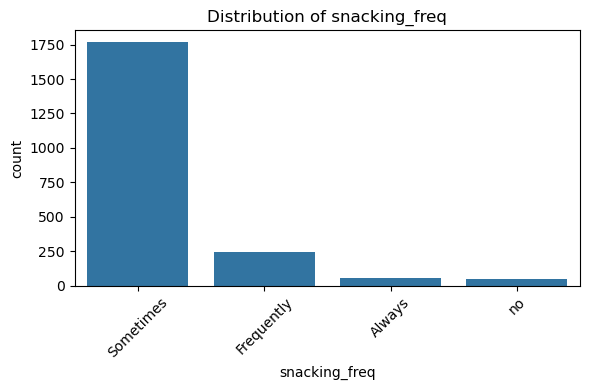

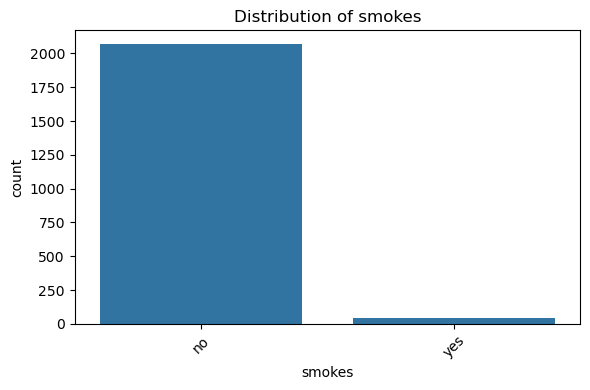

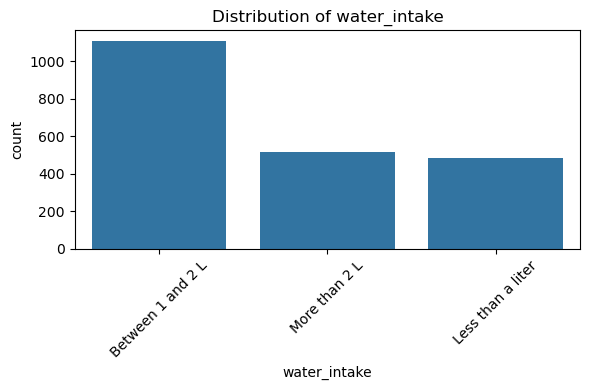

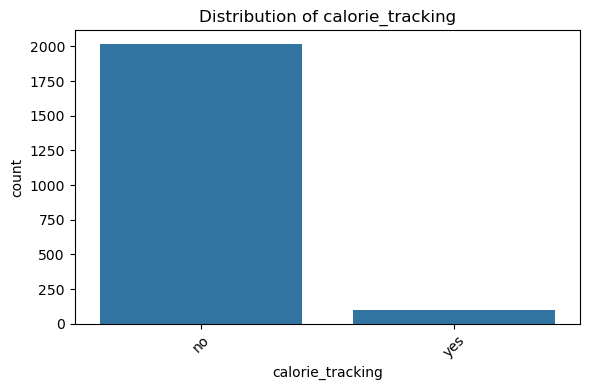

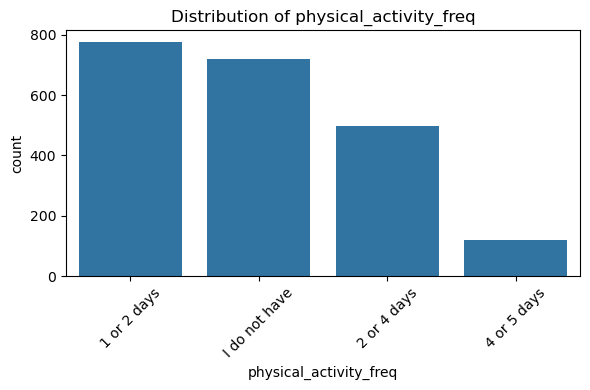

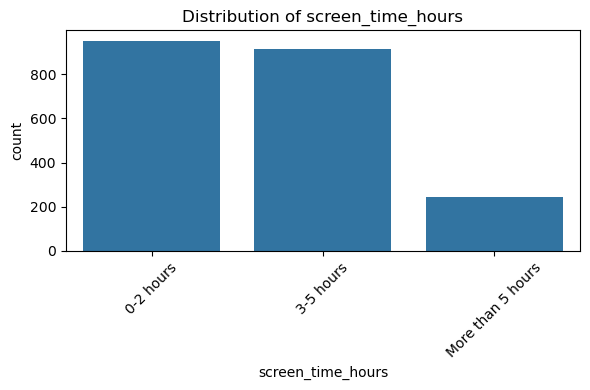

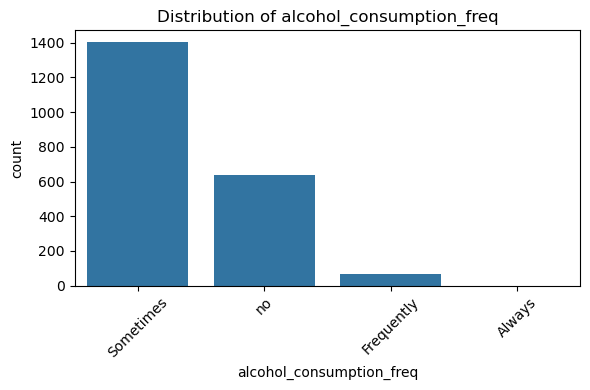

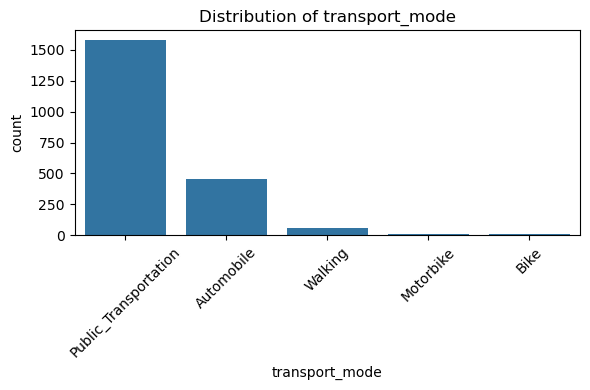

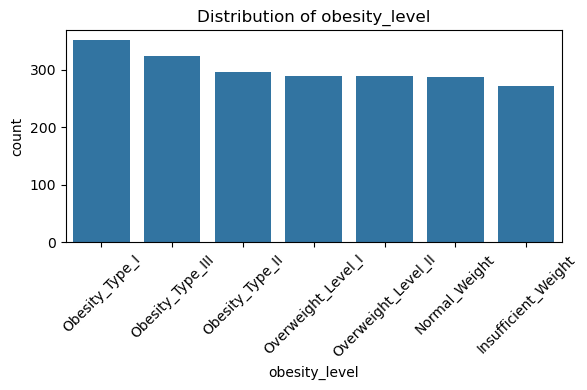

In [49]:
# Plot all categorical variables
cat_cols = df.select_dtypes(include='category').columns

for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


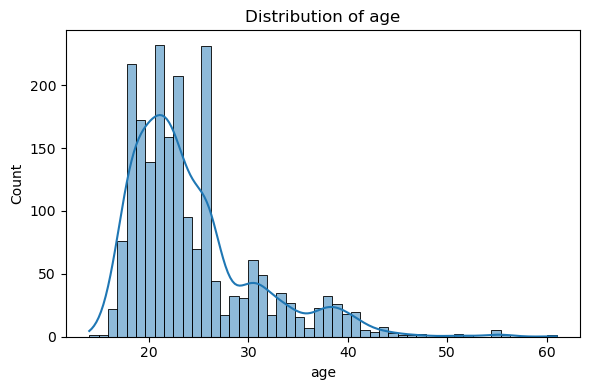

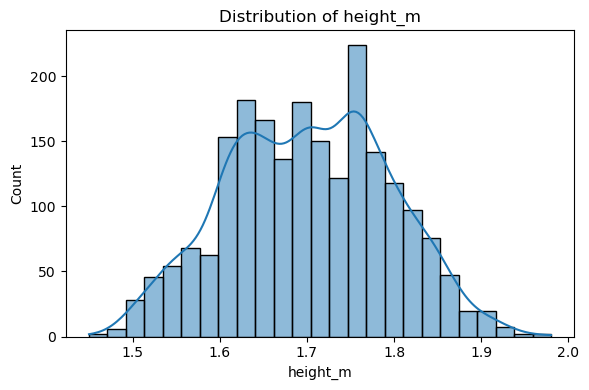

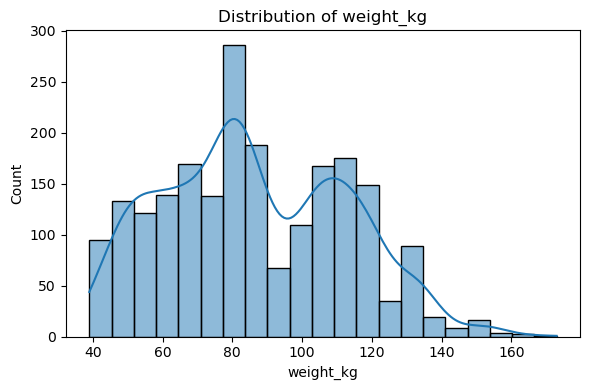

In [50]:
# Plot all numerical variables
num_cols = df.select_dtypes(include='float').columns

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


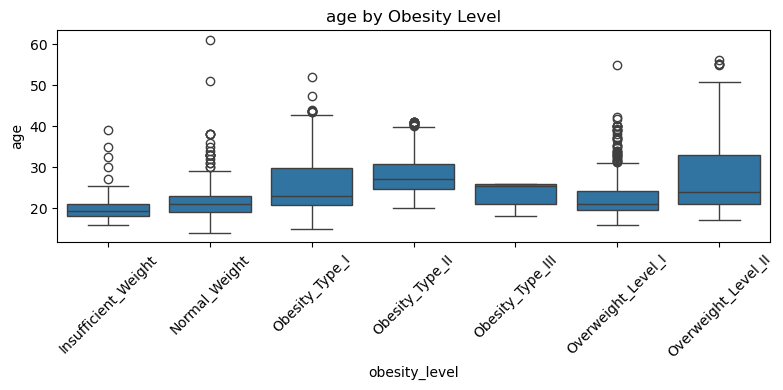

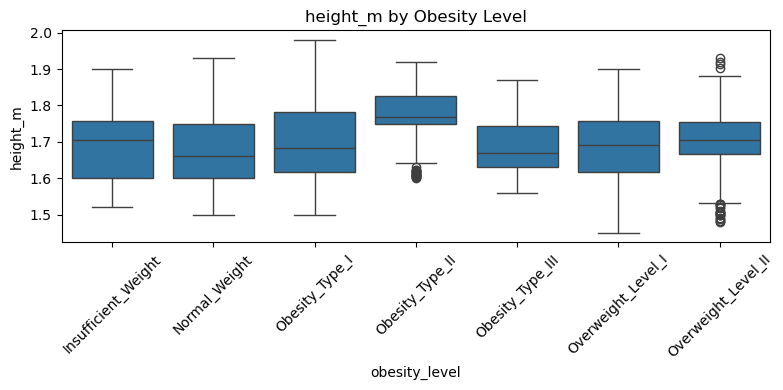

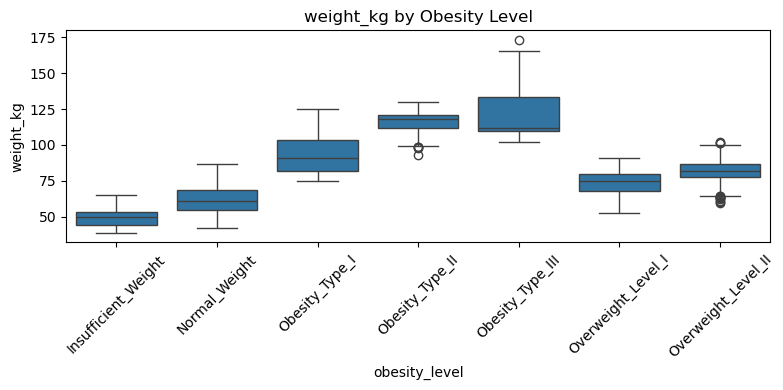

In [51]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x='obesity_level', y=col)
    plt.xticks(rotation=45)
    plt.title(f'{col} by Obesity Level')
    plt.tight_layout()
    plt.show()

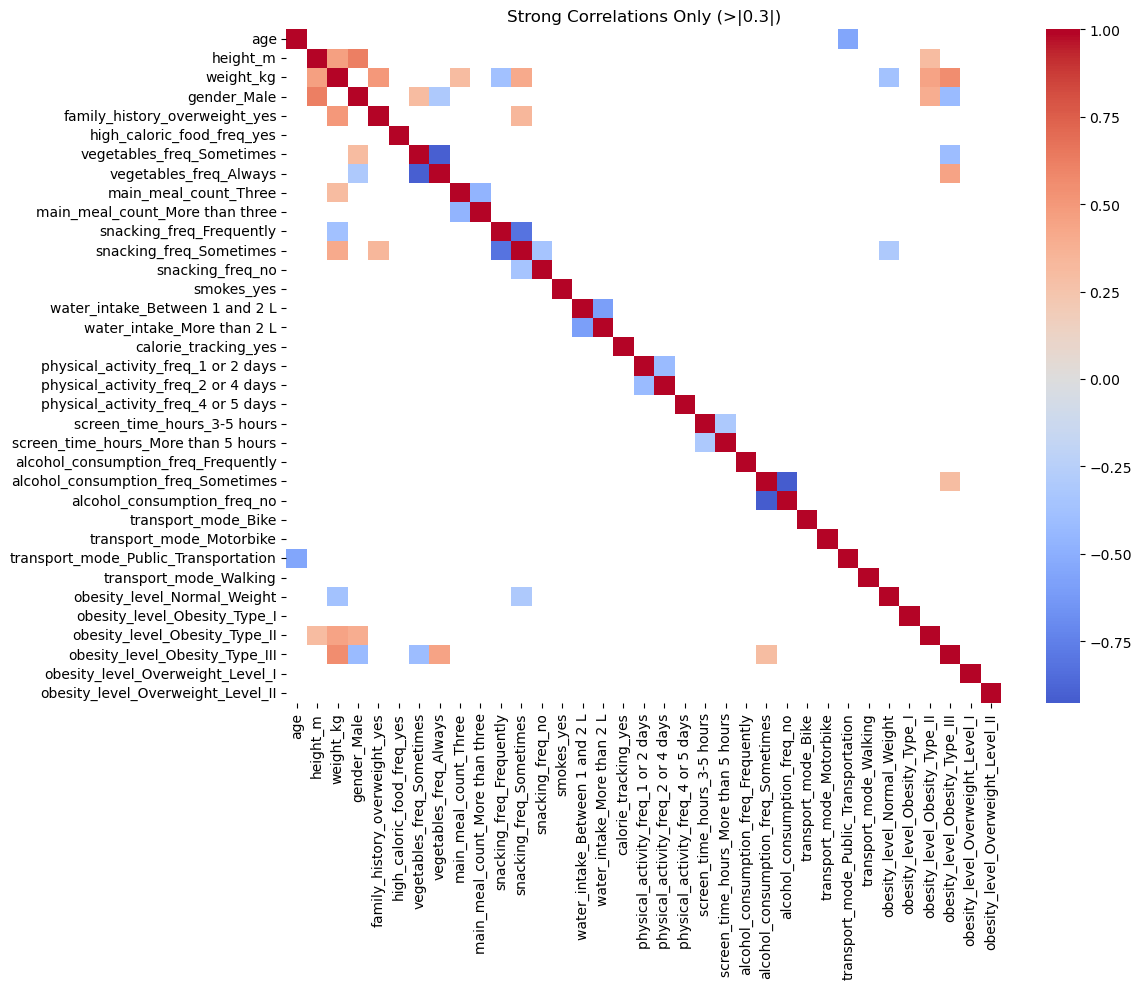

In [53]:
# One-hot encode all categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Compute correlation matrix
corr = df_encoded.corr()

# Filter strong correlations
threshold = 0.3
strong_corr = corr[(corr > threshold) | (corr < -threshold)]

plt.figure(figsize=(12, 10))
sns.heatmap(strong_corr, cmap='coolwarm', center=0)
plt.title("Strong Correlations Only (>|0.3|)")
plt.tight_layout()
plt.show()